In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [15]:
projName = "thomas_m2s"
experimentName = "shapenet13.v1"
iterName = "iter-0"
S3_BUCKET_NAME = "thomas-m2s-shapenet13-v1"

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [16]:
drop_ids = ["yoni_test", "tom_pilot0"]

In [17]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [18]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

In [19]:
df.to_csv("tom_m2s_shapenet13.v0.csv")

In [20]:
df = df[~df['userID'].isin(drop_ids)]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6432 entries, 0 to 6431
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               6432 non-null   object 
 1   img_sample        6391 non-null   object 
 2   img_target        6391 non-null   object 
 3   img_lure          6391 non-null   object 
 4   rt                6432 non-null   int64  
 5   index             6391 non-null   float64
 6   stimulus          6391 non-null   object 
 7   response          6432 non-null   object 
 8   correct           6391 non-null   object 
 9   correct_choice    6391 non-null   float64
 10  choices           6391 non-null   object 
 11  trial_type        6432 non-null   object 
 12  trial_index       6432 non-null   int64  
 13  time_elapsed      6432 non-null   int64  
 14  internal_node_id  6432 non-null   object 
 15  gameid            6391 non-null   object 
 16  iterationName     6432 non-null   object 


In [22]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [24]:
df["correct"].mean()

0.8386793928962604

In [25]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [26]:
df["correct"].mean()

0.8386793928962604

Text(0.5, 1.0, 'Accuracy per trial')

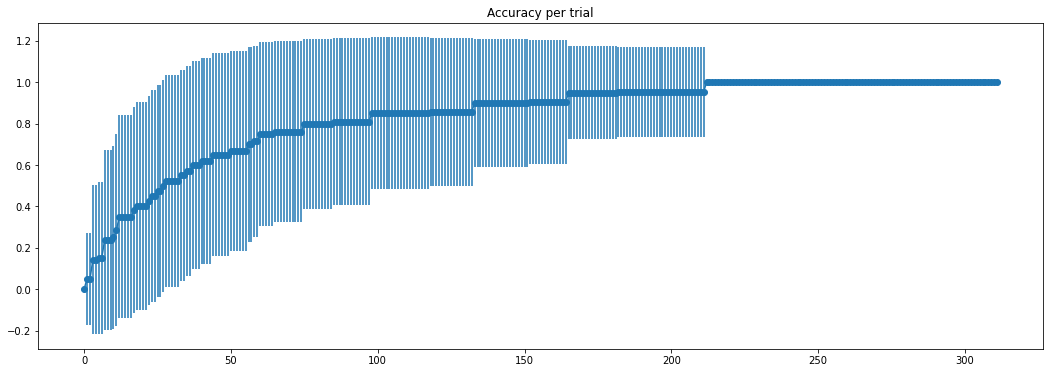

In [40]:
img_stats = []
for img, rows in df.groupby("img_sample"):
    mean = rows["correct"].mean()
    std = rows["correct"].std()
    img_stats.append([mean, std, img])
    

img_stats.sort(key=lambda x: x[0])
fig = plt.figure(figsize=(18, 6))
img_stats = np.array(img_stats)
means = img_stats[:, 0].squeeze().astype(np.float64)
stds = img_stats[:, 1].squeeze().astype(np.float64)
xs = np.arange(len(range(img_stats.shape[0])))

plt.scatter(xs, means)
plt.errorbar(xs, means, yerr=stds)
plt.title("Accuracy per trial")

# Generate cleaned version

([], [])

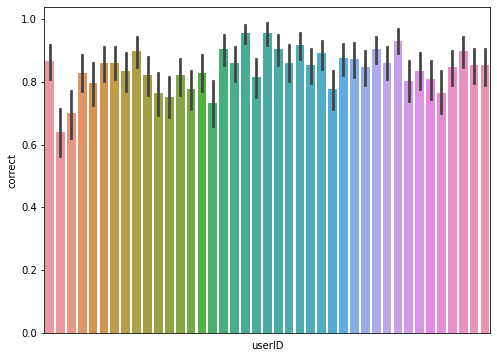

In [28]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x="userID", y="correct", data=df)
plt.xticks([])

In [ ]:
df.head()

## Let's quickly look at the comments

In [ ]:
all_comments = df[df["trial_type"] == "survey-text"]["response"]
comments = []
for response in all_comments:
    comm = response["Q0"]
    if len(comm) > 0:
        comments.append(comm)
print(comments)

In [ ]:
df.drop(df[df["trial_type"] != "plugin-2afc-task"].index, inplace=True)
df.info()

In [ ]:
participants = df.groupby("userID")
participants_failed = []
i = 0 

for index, user_results in participants:
    i += 1
    if len(user_results) < 100:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not finish the experiment")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    if user_results["correct"].mean() == 0.5:
        print("USER ID: " + user_results["userID"].iloc[0] + " did exactly 50%")
        #participants_failed.append(user_results["userID"].iloc[0])
        continue
        
    attention_checks = user_results[user_results["stimulus"].str.contains("ground_truth")]
    if attention_checks["correct"].sum() < len(attention_checks) - 3:
        num_failed = len(attention_checks) - attention_checks["correct"].sum()
        print("USER ID: " + user_results["userID"].iloc[0] + " faled " + str(num_failed) + " attention checks")
        participants_failed.append(user_results["userID"].iloc[0])

print(participants_failed)

failed_participants = df["userID"].apply(lambda x: x in participants_failed)
df = df[~failed_participants]
attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
df = df[~attention_checks]

my_data = df["userID"] == "yoni_test2"
df = df[~my_data]

In [ ]:
participants_failed

In [ ]:
print(len(df[df["userID"] == "5f4bccaefca4707a4ca6ba7d"]))

# Create directory for figures

In [ ]:
if not os.path.exists(f"figures/{experimentName}"):
    os.makedirs(f"figures/{experimentName}")

In [ ]:
n_users = len(df["userID"].unique())

## Create texture_name column

In [ ]:
stim_ex

In [ ]:
df["texture_name"] = df["stimulus"].apply(lambda x: x.split(".com/")[1].split("/")[0].split("_")[1])
df["texture_name"] = df["texture_name"].apply(lambda x: "Dots" if x == "voronoi" else x.capitalize())

In [ ]:
df["texture_scale"] = df["stimulus"].apply(lambda x: float(x[x.index("scale=")+6:x.index("scale=")+11]))
df["texture_distortion"] = df["stimulus"].apply(lambda x: float(x[x.index("rtion=")+6:x.index("rtion=")+11]))

In [ ]:
groups = df.groupby("texture_name")
max_, min_ = groups["texture_scale"].transform("max"), groups["texture_scale"].transform("min")
df["texture_scale"] = (df["texture_scale"] - min_) / (max_ - min_)
df["texture_scale"] = df["texture_scale"].apply(lambda x: float(f"{x:.03f}"))

In [ ]:
groups = df.groupby("texture_name")
max_, min_ = groups["texture_distortion"].transform("max"), groups["texture_distortion"].transform("min")
df["texture_distortion"] = (df["texture_distortion"] - min_) / (max_ - min_)
df["texture_distortion"] = df["texture_distortion"].apply(lambda x: float(f"{x:.03f}"))

In [ ]:
distances = []
for index, row in df.iterrows():
    choices = row["choices"]
    
    gt_params = row["gt_shape_params"]
    alt_params = row["alt_shape_params"]
    
    distance = np.sqrt((gt_params[0] - alt_params[0])**2 + (gt_params[1] - alt_params[1]) ** 2) 

    distances.append(distance)
    
df["distances"] = distances

In [ ]:
fig = plt.figure(figsize=(16,12))
g = sns.barplot(y="correct", x="userID", data=df)
g.set(xticklabels=[])
plt.xlabel("User")
plt.ylabel("Accuracy")
plt.title(f"Accuracy per user (n={n_users}, mean={df['correct'].mean():.02f})", fontsize=24)

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.countplot(x="batch", data=df)
plt.xticks(range(10), range(10))
plt.show()

In [ ]:
figure = plt.figure(figsize=(16,12))
sns.barplot(x="texture_scale", y="correct", hue="texture_name", data=df)
plt.xlabel("Texture Scale")
plt.xticks(range(3), ["Small", "Medium", "Large"])

plt.ylabel("Correct")
plt.title("Texture Scale vs. Accuracy")
plt.show()

In [ ]:
figure = plt.figure(figsize=(16,12))
sns.barplot(x="texture_distortion", y="correct", hue="texture_name", data=df)
plt.xlabel("Texture Distortion")
plt.xticks(range(3), ["Low", "Medium", "High"])

plt.ylabel("Correct")
plt.title("Texture distortion vs. Accuracy")
plt.show()

In [ ]:
sns.histplot(df["distances"])
plt.title("Distribution of euclidean distance between distractors")

In [ ]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Participant Accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

In [ ]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
figure = plt.figure(figsize=(12,8))
g = sns.histplot(x=accuracies, binwidth=0.1, stat="probability")
plt.xlim(0, 1)

plt.xlabel("Mean Accuracy")
plt.ylabel(f"% of Stimuli (n={len(accuracies)})")
plt.title(f"Stimulus level accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

# Accuracy across all textures

In [ ]:
accuracies = []
textures = []
target = "stimulus"

for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    accuracies.append(accuracy)
    if trials["texture_name"].iloc[0] == "":
        continue
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf, order=["Dots", "Noise", "Wave"])

plt.xlabel("Texture type")
plt.ylabel(f"Accuracy per stimuli")
plt.title(f"Accuracy per-image across stimuli (~5 repeats per-stimuli)")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


In [ ]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby([target, "texture_name"]): 
    accuracy = trials["correct"].mean()

    
    accuracies.append(accuracy)
    textures.append(trials["texture_name"].iloc[0])
    
    
tempdf = pd.DataFrame({"textures": textures, "accuracies": accuracies})

figure = plt.figure(figsize=(12,8))
sns.boxplot(y="accuracies", x="textures", data=tempdf, order=["Dots", "Noise", "Wave"])

plt.xlabel(f"Texture type")
plt.ylabel(f"Accuracy")
plt.title(f"Accuracy across users by texture")
# plt.savefig(f"figures/{EXPERIMENT_NAME}/mean_accuracy_hist_per_{target}.png")


In [ ]:
sns.histplot(df["batch"], binwidth=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.histplot(df["distances"])
g = sns.kdeplot(df["distances"], ax=ax)
plt.show()

In [ ]:
c = Counter()
for i, row in df.iterrows():
    dist = row["distances"]
    correct = row["correct"]
    c[dist] += correct

In [ ]:
bins = np.linspace(df["distances"].min(), df["distances"].max(), 20)

df["dist_binned"] = pd.cut(df["distances"], np.linspace(df["distances"].min(), df["distances"].max(), 20), 
                           labels=False)

In [ ]:
df["distractor_shape_type"] = df["alt_shape_url"].apply(lambda x: x.split("_")[0].split("/")[-1])
df["shape_matching"] = df["distractor_shape_type"] == df["obj_shape_type"]

In [ ]:
dists = []
means = []
sample_sizes = []
matching = []
for (stim, dist, shape_matching), row in df.groupby(["stimulus", "dist_binned", "shape_matching"]):
    dists.append(dist)
    means.append(row["correct"].mean())
    sample_sizes.append(len(row))
    matching.append(shape_matching)
    
    
tempdf = pd.DataFrame({"dists": dists, "means": means, "Same-class distractor": matching, 
                       "sample_sizes": sample_sizes})

fig = plt.figure(figsize=(16,8))
g = sns.lmplot(x="dists", y="means", scatter=True, col="Same-class distractor", hue="Same-class distractor", data=tempdf, 
           sharex=True, sharey=True, aspect=1.5, x_jitter=0.05, line_kws={"linewidth": 4})
g.set_axis_labels("Binned Distractor Distance", "Per-Stimuli Accuracy").fig.subplots_adjust(wspace=.1)


for ax in g.axes.flat:
    ax.set_xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.suptitle(f"Per-Stimuli Accuracy by Distractor Distance  (n={len(sample_sizes) + 1})", y=1.05)
plt.xlabel("Binned Distractor Distace")
plt.ylabel(f"Per-Stimuli accuracy")
plt.show()

In [ ]:
dists = []
means = []
sample_sizes = []
matching = []
for (stim, dist, shape_matching), row in df.groupby(["userID", "dist_binned", "shape_matching"]):
    dists.append(dist)
    means.append(row["correct"].mean())
    sample_sizes.append(len(row))
    matching.append(shape_matching)
    
    
tempdf = pd.DataFrame({"dists": dists, "means": means, "Same-class distractor": matching, 
                       "sample_sizes": sample_sizes})

fig = plt.figure(figsize=(16,8))
g = sns.lmplot(x="dists", y="means", scatter=True, col="Same-class distractor", hue="Same-class distractor", data=tempdf, 
           sharex=True, sharey=True, aspect=1.5, x_jitter=0.05, line_kws={"linewidth": 4})
g.set_axis_labels("Binned Distractor Distance", "Per-User Accuracy").fig.subplots_adjust(wspace=.1)


for ax in g.axes.flat:
    ax.set_xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.suptitle(f"Per-User Accuracy by Distractor Distance (n={n_users})", y=1.05)
plt.xlabel("Binned Distractor Distace")
plt.ylabel(f"Per-User Accuracy")
plt.show()

In [ ]:
dists = []
means = []
sample_sizes = []
for (user, dist), row in df.groupby(["userID", "dist_binned"]):
    dists.append(dist)
    means.append(row["correct"].mean())
    sample_sizes.append(len(row))
 

m, b, r, p, stderr = stats.linregress(distances, correct)
print(f"Slope: {m:.02f}, \nIntercept: {b:.02f}, \nR^2: {r:.02f}, \nP-val: {p:.05f}, \nStd Error: {stderr:.02f}")

fig = plt.figure(figsize=(12,8))
sns.regplot(x=dists, y=means, scatter=True, x_jitter=0.1)
plt.title(f"Per-User Accuracy by Distractor Distance (n={n_users})")
plt.xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.xlabel("Binned Distractor Distace")
plt.ylabel("Per-user accuracy")
plt.show()

In [ ]:
dists = []
means = []
sample_sizes = []
for dist, row in df.groupby(["dist_binned"]):
    dists.append(dist)
    means.append(row["correct"].mean())
    sample_sizes.append(len(row))
 

m, b, r, p, stderr = stats.linregress(distances, correct)
print(f"Slope: {m:.02f}, \nIntercept: {b:.02f}, \nR^2: {r:.02f}, \nP-val: {p:.05f}, \nStd Error: {stderr:.02f}")

fig = plt.figure(figsize=(12,8))
sns.regplot(x=dists, y=means, scatter=True, x_jitter=0.1, y_jitter=0.1)
plt.title("Average Accuracy by Distractor Distance")
plt.xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.xlabel("Binned Distractor Distace")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import scipy.stats as stats

distances = []
correct = []
for dist, rows in df.groupby(["dist_binned"]):
    distances.append(dist)
    correct.append(rows["correct"].mean())

    
m, b, r, p, stderr = stats.linregress(distances, correct)

print(f"Slope: {m:.02f}, \nIntercept: {b:.02f}, \nR^2: {r:.02f}, \nP-val: {p:.05f}, \nStd Error: {stderr:.02f}")

fig = plt.figure(figsize=(12,8))
sns.regplot(x=distances, y=correct, order=1)

plt.xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.xlabel("Distractor Distance (binned)")
plt.ylabel("Average Correct Responses")
plt.title("Accuracy by Distractor Distance")
plt.show()

In [ ]:
def add_probe(ax, location):
    
    probe = patches.Circle(location, radius=12, color="#69597f", alpha=0.8)
    ax.add_patch(probe)

    probe = patches.Circle(location, radius=4, color="#ff0601", alpha=1)
    ax.add_patch(probe)
    
def view_trials(df, filter_correct=False):
    if filter_correct:
        df = df[df["correct"] != True]
        
    for stimulus, rows in df.groupby("stimulus"):
        plt.close()
        
        row = rows.iloc[0]            
                
        stim_img = download_from_url(stimulus)
        probe_location = row["probe_location"]
        
        gt_img = download_from_url(row["gt_shape_url"])
        alt_img = download_from_url(row["alt_shape_url"])
        
        fig = plt.figure(constrained_layout=True, figsize=(12, 12))
        axs = fig.subplot_mosaic("""AA
                                    BC
                                    """)
        axs["A"].imshow(stim_img, cmap="gray")
        add_probe(axs["A"], probe_location)
        
        axs["B"].imshow(gt_img)
        axs["C"].imshow(alt_img)
        
        
        axs["A"].set_title("Stimulus")
        axs["B"].set_title("Correct Answer")
        axs["C"].set_title(f"Distractor Image (d={row['distances']:.03f})")

        plt.show()

In [ ]:
view_trials(df)

In [ ]:
figure = plt.figure(figsize=(12,8))
df["rt_seconds"] = df["rt"] / 1000
sns.scatterplot(x="distances", y="rt_seconds", hue="userID", data=df)
plt.ylabel("Response Time (s)")
plt.xlabel("Distractor Distance")
plt.legend("")
plt.title("Distractor distance by response time")
plt.show()

In [ ]:
dists = []
response_times = []
sample_sizes = []
df["rt_s"] = df["rt"] / 1000

for (dist), row in df.groupby(["dist_binned"]):
    dists.append(dist)
    response_times.append(row["rt_s"].mean())
    sample_sizes.append(len(row))
    
    
tempdf = pd.DataFrame({"dists": dists, "response_times": response_times,
                       "sample_sizes": sample_sizes})

fig = plt.figure(figsize=(16,8))
g = sns.regplot(x=dists, y=response_times, scatter=True, 
             x_jitter=0.05, line_kws={"linewidth": 4})

plt.xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.suptitle(f"Response Time by Distractor Distance", y=.98)
plt.xlabel("Binned Distractor Distace")
plt.ylabel(f"Average Response Times (s)")
plt.show()

In [ ]:
dists = []
response_times = []
sample_sizes = []
matching = []

for (dist, shape_matching), row in df.groupby(["dist_binned", "shape_matching"]):
    dists.append(dist)
    response_times.append(row["rt_s"].mean())
    sample_sizes.append(len(row))
    matching.append(shape_matching)
    
    
tempdf = pd.DataFrame({"dists": dists, "response_times": response_times, "Same-class distractor": matching, 
                       "sample_sizes": sample_sizes})

fig = plt.figure(figsize=(16,8))
g = sns.lmplot(x="dists", y="response_times", scatter=True, col="Same-class distractor", hue="Same-class distractor", data=tempdf, 
           sharex=True, sharey=True, aspect=1.5, x_jitter=0.05, line_kws={"linewidth": 4})

g.set_axis_labels("Binned Distractor Distance", "Response Times (s)").fig.subplots_adjust(wspace=.1)
for ax in g.axes.flat:
    ax.set_xticks(range(20), [f"{b:.02f}" for b in bins], rotation=45)

plt.suptitle(f"Response Times by Distractor Distance", y=1.05)
plt.xlabel("Binned Distractor Distace")

plt.show()